In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

### Load dataset:

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 28447245.09it/s]                            


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


32768it [00:00, 454219.02it/s]
  1%|          | 16384/1648877 [00:00<00:11, 144109.19it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:00, 7557387.78it/s]                            
8192it [00:00, 172219.77it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


### Define NN:

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 4, 3)
    self.conv2 = nn.Conv2d(4, 8, 3)
    self.conv3 = nn.Conv2d(8, 16, 3)
    self.fc1 = nn.Linear(4608, 100)
    self.fc2 = nn.Linear(100, 10)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    # print('HUY', x.shape)
    # x = F.softmax(x, dim=1)
    x = F.log_softmax(x, dim=1)
    # We use log_softmax because loss function CrossEntropyLoss expects log_softmax, proof:
    # https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss
    
    # print(x.shape)
    # print('HERE!!!', x[0].sum())
    return x
  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

In [36]:
# Just several examples how softmax and log_softmax work
data = torch.tensor([[1.,2,3,4,5, 9], [-100, 10, 2., 5, 6, -10]])
print(data)
print(F.softmax(data, dim=1))
print(F.softmax(data, dim=1).sum())
print(F.log_softmax(data, dim=1))

tensor([[   1.,    2.,    3.,    4.,    5.,    9.],
        [-100.,   10.,    2.,    5.,    6.,  -10.]])
tensor([[3.2608e-04, 8.8637e-04, 2.4094e-03, 6.5495e-03, 1.7803e-02, 9.7203e-01],
        [0.0000e+00, 9.7524e-01, 3.2716e-04, 6.5711e-03, 1.7862e-02, 2.0101e-09]])
tensor(2.0000)
tensor([[-8.0284e+00, -7.0284e+00, -6.0284e+00, -5.0284e+00, -4.0284e+00,
         -2.8373e-02],
        [-1.1003e+02, -2.5072e-02, -8.0251e+00, -5.0251e+00, -4.0251e+00,
         -2.0025e+01]])


In [0]:
net = Net()

In [22]:
# Just in order to get the shape of images
next(iter(train_loader))[0].shape

torch.Size([64, 1, 28, 28])

### Get summary of model:

In [23]:
from torchsummary import summary
summary(net, input_size=(1, 28, 28)) # 1, 1, 32, 32

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
            Conv2d-2            [-1, 8, 24, 24]             296
            Linear-3                  [-1, 100]         460,900
            Linear-4                   [-1, 10]           1,010
Total params: 462,246
Trainable params: 462,246
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 1.76
Estimated Total Size (MB): 1.82
----------------------------------------------------------------


### Define Loss and Optimizer:

In [0]:
# Define loss function:
criterion = torch.nn.CrossEntropyLoss()
# Define optimizer: 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [25]:
# Just to ckeck that before training it is 10% accuracy:
x_test, y_test = next(iter(test_loader))

outputs_test = net(x_test)
_, predicted = torch.max(outputs_test, 1)
predicted
(predicted == y_test).sum().item() / 64

0.09375

### Training:

In [32]:
for epoch in range(2): # epochs loop
  net.train() # for enable Dropout. When net.eval() => Dropout is disabled
  running_loss = 0.0
  j = 0
  
  for data, labels in train_loader: # loop over data
    j += 1
    optimizer.zero_grad()
    
    outputs = net(data)
    # _, predicted = torch.max(outputs, 1)
    
    # print(outputs.shape)
    # print(labels.shape)
    
    loss = criterion(outputs, labels) # CrossEntropy
    loss.backward()
    
    optimizer.step()
    
    # print statistics
    running_loss += loss.item()
    if j % 200 == 199:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, j + 1, running_loss / 2000))
        running_loss = 0.0

[1,   200] loss: 0.160
[1,   400] loss: 0.038
[1,   600] loss: 0.029
[1,   800] loss: 0.025
[2,   200] loss: 0.020
[2,   400] loss: 0.018
[2,   600] loss: 0.017
[2,   800] loss: 0.016


### Check on test data:

In [0]:
def check_quality(test_loader):
  accuracy_list = []
  for x_test, y_test in test_loader:
    outputs_test = net(x_test)
    _, predicted = torch.max(outputs_test, 1)
    temp_acc = (predicted == y_test).sum().item() / 64
    accuracy_list.append(temp_acc)
  return accuracy_list

In [34]:
check_quality(test_loader)

[0.953125,
 0.9375,
 0.9375,
 0.953125,
 0.96875,
 0.9375,
 1.0,
 0.9375,
 0.953125,
 0.953125,
 0.96875,
 0.96875,
 0.96875,
 0.984375,
 0.96875,
 0.96875,
 0.984375,
 0.96875,
 0.96875,
 0.984375,
 1.0,
 0.9375,
 0.953125,
 0.96875,
 0.96875,
 0.96875,
 0.9375,
 0.984375,
 1.0,
 0.90625,
 0.984375,
 0.90625,
 1.0,
 0.9375,
 0.984375,
 0.921875,
 0.953125,
 1.0,
 1.0,
 0.953125,
 0.953125,
 0.984375,
 0.953125,
 0.984375,
 0.953125,
 0.96875,
 0.953125,
 0.921875,
 0.9375,
 0.96875,
 0.96875,
 0.921875,
 0.953125,
 0.9375,
 0.984375,
 1.0,
 0.96875,
 0.9375,
 0.984375,
 0.921875,
 0.96875,
 0.953125,
 0.9375,
 0.953125,
 0.953125,
 0.96875,
 0.953125,
 0.96875,
 0.984375,
 0.984375,
 0.9375,
 1.0,
 0.953125,
 0.953125,
 0.9375,
 0.953125,
 0.96875,
 1.0,
 0.953125,
 0.96875,
 0.984375,
 1.0,
 0.96875,
 0.96875,
 0.984375,
 0.984375,
 0.984375,
 0.9375,
 0.984375,
 0.984375,
 0.953125,
 0.96875,
 0.953125,
 0.953125,
 0.90625,
 0.96875,
 0.953125,
 0.953125,
 0.953125,
 0.984375,
 0.93

In [18]:
acc_list = check_quality(test_loader)
sum(acc_list) / len(acc_list)

0.9522292993630573

### Same for one batch of images:

In [0]:
x_test, y_test = next(iter(test_loader))

In [38]:
print(x_test.shape)
print(y_test.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [40]:
outputs_test = net(x_test)
outputs_test

tensor([[-8.7920e+00, -1.2415e+01, -3.7741e+00, -2.0074e+00, -3.7990e+00,
         -6.2691e+00, -9.1518e+00, -4.7923e+00, -2.9622e-01, -2.7146e+00],
        [-1.6456e+01, -1.7466e+01, -6.0714e+00, -1.0595e+01, -1.3641e+01,
         -1.5363e+01, -2.1295e+01, -2.5913e-03, -1.0887e+01, -8.3572e+00],
        [-2.5262e+01, -2.1352e+01, -9.9324e+00, -9.7488e+00, -1.9490e+01,
         -2.1838e+01, -2.7233e+01, -1.1134e-04, -1.3094e+01, -1.2967e+01],
        [-1.5652e+01, -1.3488e+01, -1.2040e+01, -1.0595e+01, -1.9812e+01,
         -1.3047e+01, -2.1133e+01, -1.8829e+01, -3.6477e-05, -1.3241e+01],
        [-1.2013e+01, -1.7937e+01, -1.6591e+01, -1.6937e+01, -1.5699e+01,
         -2.2822e-03, -1.7981e+01, -6.9231e+00, -6.6544e+00, -1.5968e+01],
        [-6.2207e-03, -1.0862e+01, -9.5617e+00, -1.2535e+01, -1.1582e+01,
         -5.9140e+00, -6.2201e+00, -8.9278e+00, -7.7311e+00, -7.0856e+00],
        [-2.0059e+01, -1.1619e+01, -7.4253e+00, -6.4105e+00, -9.2299e+00,
         -1.3781e+01, -1.6518e+0

In [42]:
_, predicted = torch.max(outputs_test, 1)
predicted

tensor([8, 7, 7, 8, 5, 0, 7, 8, 7, 6, 0, 4, 9, 3, 5, 7, 9, 1, 8, 0, 8, 1, 9, 6,
        1, 7, 3, 7, 9, 2, 0, 8, 0, 0, 8, 5, 5, 1, 8, 5, 8, 1, 5, 3, 7, 9, 7, 8,
        7, 3, 9, 3, 8, 3, 4, 7, 5, 2, 9, 1, 4, 0, 1, 1])

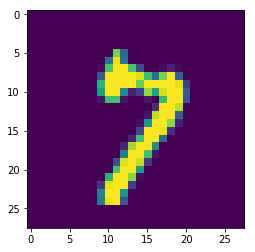

In [43]:
# Show image
%matplotlib inline 
plt.imshow(x_test[1].numpy().squeeze(), interpolation='nearest')
plt.show()

In [44]:
(predicted == y_test).sum().item() / 64

0.984375